# Probar la extracción de datos y análisis para la API de BingX

In [15]:
import os
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

interval | field description
---------|-----------------
1m | One-minute K line
3m | Three-minute K line
5m | Five-minute K line
15m | 15 minutes K line
30m | Thirty minutes K line
1h | One-hour candlestick line
2h | Two-hour K-line
4h | Four-hour K line
6h | Six-hour K line
8h | Eight-hour K-line
12h | 12-hour K line
1d | 1 day candlestick
3d | 3-day K-line
1w | Weekly K-line
1M | Monthly candlestick

In [16]:
def past_timestamp(cantidad, periodo):
    "Devuelve en milisegundos el timestamp de hace 'cantidad' 'periodo'"
    if periodo == "min":
        delta = datetime.timedelta(minutes=cantidad)
    elif periodo == "hour":
        delta = datetime.timedelta(hours=cantidad)
    elif periodo == "days":
        delta = datetime.timedelta(days=cantidad)
    else:
        raise ValueError("Período inválido")
    
    now = datetime.datetime.now()
    past = now - delta
    timestamp = datetime.datetime.timestamp(past)
    return timestamp * 1000

def now_timestamp():
    "devuelve en milisegundos el timestamp actual"
    return datetime.datetime.timestamp(datetime.datetime.now()) * 1000

def response_to_dataframe(response):
    data = response['data']
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df[['open', 'close', 'high', 'low', 'volume']] = df[['open', 'close', 'high', 'low', 'volume']].astype(float)
    return df

def guardar_csv(path_output, data):
    """
    Guarda un DataFrame como archivo CSV en la ruta especificada.

    Argumentos:
    - path_output: ruta relativa o absoluta donde se guardará el archivo CSV.
    - data: DataFrame a guardar como archivo CSV.

    """
    # Obtener el path absoluto del archivo de salida
    path_absoluto_output = os.path.abspath(path_output)
    print('Guardando en ubicación:')
    print(path_absoluto_output)
    # Abrir el archivo de salida
    with open(path_absoluto_output, 'w') as archivo_output:
        # Guardar el archivo csv
        data.to_csv(archivo_output, index=False)


In [17]:
URL = 'https://open-api.bingx.com'
path = '/openApi/swap/v2/quote/klines'
method = 'GET'

service = URL + path

symbol = 'BTC-USDT'
interval = '15m'
limit = 1440  #default 500, max 1440

startTime = int(past_timestamp(1400, 'min'))
endTime = int(now_timestamp())

if True:
    response = requests.request(method, service, params={'symbol':symbol, 'interval':interval, 'limit':limit, 'startTime':startTime, 'endTime':endTime})
    df = response_to_dataframe(response.json())
    guardar_csv('data-15m.csv', df) 
else:
    df = pd.read_csv('data.csv')


Guardando en ubicación:
c:\Users\Agustin\Desktop\Zartex\BingX\data-15m.csv


In [18]:
df

,open,close,high,low,volume,time
0,29011.5,29071.5,29099.5,28995.0,508.79,2023-04-28 15:15:00
1,29071.5,29092.0,29103.5,29048.5,405.34,2023-04-28 15:30:00
2,29092.0,29144.0,29171.5,29084.0,425.15,2023-04-28 15:45:00
3,29144.0,29253.5,29269.5,29135.0,604.05,2023-04-28 16:00:00
4,29253.5,29142.0,29253.5,29103.0,566.68,2023-04-28 16:15:00
...,...,...,...,...,...,...
87,29278.0,29297.0,29299.5,29277.0,121.47,2023-04-29 13:00:00
88,29297.0,29343.5,29356.0,29296.5,342.59,2023-04-29 13:15:00
89,29343.5,29335.5,29351.5,29320.0,137.91,2023-04-29 13:30:00
90,29335.5,29380.0,29386.0,29320.0,310.66,2023-04-29 13:45:00


In [19]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = (
        dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] * 100 - 100
    )
    return data




# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data['close'].diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1 / ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1 / ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1 + dataux.loc[:, "rs"]))
    return data




# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "close"].pct_change() * 100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (
        sigma**0.5
    )
    return data




def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data['close'].shift(-step) / data['close'].shift() - 1) * 100
    return data




def ajustar_datos(data, features):
    data = data.iloc[:, 3:].dropna()
    data.loc[:, features] = data.loc[:, features].shift()
    return data.round(4)

# PARAMETROS INCIALES
ruedas = 14
fast, slow = 20, 60
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"]  # atributo dinámico
forwards = [f"fw_{i}" for i in fw]  # atributo preseteado, dinámico

df = cruce_sma_fast_slow(df, fast, slow)
df = rsi(df, ruedas)
df = volatilidad(df, sigma)
df = forward(df, fw)
df = ajustar_datos(df, features)

df

,low,volume,time,Cruce_20_60,rsi,variacion,sigma_40,fw_10,fw_20
59,29350.0,139.93,2023-04-29 06:00:00,NaN,NaN,0.0000,NaN,-0.1448,-0.2879
60,29316.5,191.70,2023-04-29 06:15:00,0.1599,52.1944,-0.1243,0.6142,-0.1465,-0.3424
61,29311.5,161.16,2023-04-29 06:30:00,0.1525,46.0345,0.0085,0.6084,-0.1723,-0.1143
62,29285.5,259.14,2023-04-29 06:45:00,0.1485,46.5002,0.0136,0.6084,-0.0955,0.0273
63,29323.0,240.21,2023-04-29 07:00:00,0.1472,47.2841,0.0460,0.6058,-0.1603,-0.0222
64,29293.0,380.12,2023-04-29 07:15:00,0.1503,49.9496,-0.0818,0.6075,-0.1432,-0.1159
65,29293.5,184.14,2023-04-29 07:30:00,0.1392,45.5410,0.0768,0.6120,-0.0972,-0.0443
66,29335.0,98.97,2023-04-29 07:45:00,0.1268,49.9968,0.0222,0.6161,-0.2471,-0.1960
67,29300.0,166.77,2023-04-29 08:00:00,0.1175,51.2380,-0.0852,0.6162,-0.2641,-0.1534
68,29270.5,330.90,2023-04-29 08:15:00,0.1045,46.4610,-0.0631,0.5944,-0.1808,0.0904


In [20]:
for feature in features:
    r2 = df[feature].corr(df.variacion)
    print(f"El r2 con {feature} es {r2:.2f}")

df.corr().loc[["variacion"] + forwards, features].round(2)

El r2 con Cruce_20_60 es 0.19
El r2 con rsi es -0.51
El r2 con sigma_40 es 0.40


C:\Users\Agustin\AppData\Local\Temp\ipykernel_11052\1795977711.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().loc[["variacion"] + forwards, features].round(2)


,Cruce_20_60,rsi,sigma_40
variacion,0.19,-0.51,0.40
fw_10,-0.01,-0.56,-0.43
fw_20,-0.77,-0.81,-0.70


In [21]:
df["variacion_tipo"] = np.where(df.variacion > 0, "Up", "Down")

medias = df.groupby("variacion_tipo").mean().loc[:, features].round(2)
desvios = df.groupby("variacion_tipo").std().loc[:, features].round(2)

print(f"Medias según clasificación \n{medias}\n")
print(f"Desvíos según clasificación \n{desvios}\n")

Medias según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   0.11  48.61      0.60
Up                     0.13  46.43      0.61

Desvíos según clasificación 
                Cruce_20_60   rsi  sigma_40
variacion_tipo                             
Down                   0.04  2.85      0.02
Up                     0.02  2.21      0.01



C:\Users\Agustin\AppData\Local\Temp\ipykernel_11052\2174588580.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias = df.groupby("variacion_tipo").mean().loc[:, features].round(2)
C:\Users\Agustin\AppData\Local\Temp\ipykernel_11052\2174588580.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  desvios = df.groupby("variacion_tipo").std().loc[:, features].round(2)


[(-0.25, 0.25)]

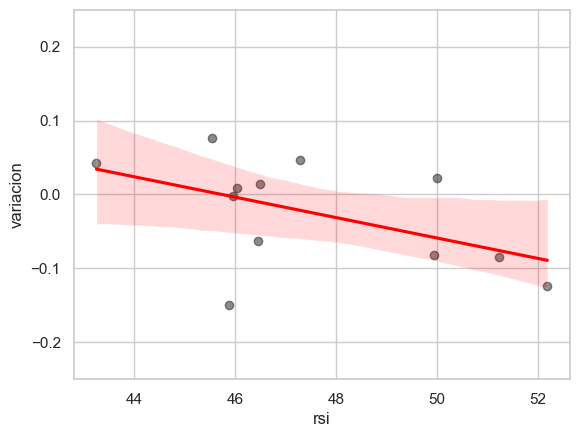

In [22]:
sns.set(style="whitegrid")
g = sns.regplot(
    x="rsi",
    y="variacion",
    data=df,
    line_kws={"color": "red"},
    scatter_kws={"color": "k", "alpha": 0.5},
)

g.set(ylim=(-0.25, 0.25))

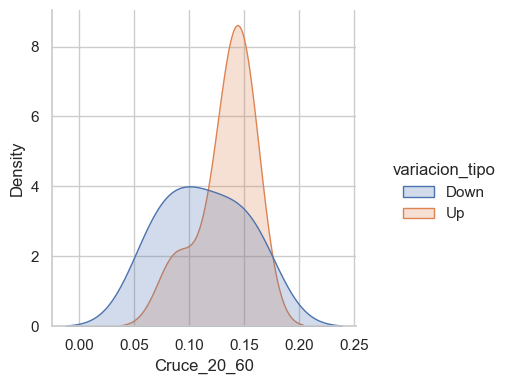

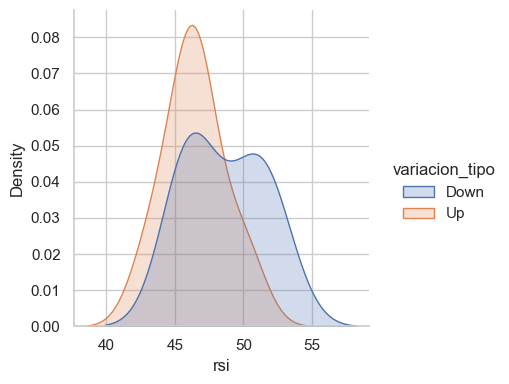

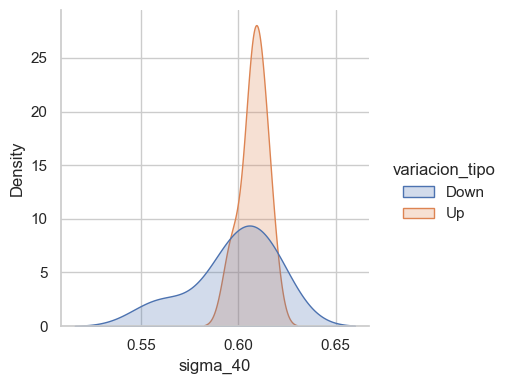

In [23]:
for feature in features:
    sns.displot(df, x=feature, hue="variacion_tipo", kind="kde", height=4, fill=True)